<a href="https://colab.research.google.com/github/Rokuske/Data/blob/main/DataFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn import metrics

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# 1 Работа с данными

## 1.1 Первичная обработка

In [ ]:
#Подключаемся к гугл диску
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Studies/DataFusion/transactions_finetune.csv')
df

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,69,5541,48,-342.89792,2021-03-05 02:52:36
1,69,5533,48,-1251.88120,2021-03-05 09:43:28
2,69,5331,48,-87.30924,2021-03-05 11:17:23
3,69,5921,48,-1822.17700,2021-03-05 13:41:03
4,69,5311,48,-427.12363,2021-03-05 19:14:23
...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44


In [ ]:
target = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Studies/DataFusion/target_finetune.csv')
target

,user_id,target
0,452772,0
1,64288,0
2,504497,0
3,566270,0
4,328558,0
...,...,...
7075,237771,0
7076,347012,0
7077,358770,0
7078,292937,0


Соотношение дефолтников и не дефолтников

In [ ]:
target['target'].value_counts()

0    6818
1     262
Name: target, dtype: int64

In [ ]:
262/6818

0.03842769140510414

Расшифровка mcc

In [ ]:
mcc = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML Studies/DataFusion/mcc_codes.csv')
mcc

,MCC,Название,Описание
0,742,Ветеринарные услуги,Лицензированные специалисты в основном занимаю...
1,763,Сельскохозяйственные кооперативы,"Ассоциации и кооперативы, которые предоставляю..."
2,780,Услуги садоводства и ландшафтного дизайна,Ландшафтные архитекторы и другие поставщики ус...
3,1520,Генеральные подрядчики – жилое и коммерческое ...,"Генеральные подрядчики, в основном занимающиес..."
4,1711,"Генеральные подрядчики по вентиляции, теплосна...","Специальные торговые подрядчики, которые работ..."
...,...,...,...
380,9311,Налоговые платежи,"Местные, региональные и федеральные организаци..."
381,9399,Государственные услуги - нигде более не класси...,"Торговые точки, предоставляющие правительству ..."
382,9402,Почтовые услуги – только государственные,"Государственные почтовые отделения, включая ме..."
383,9405,Внутригосударственные закупки - только государ...,Определяет транзакции между правительственными...


Просмотр типов данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124000 entries, 0 to 2123999
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           int64  
 1   mcc_code          int64  
 2   currency_rk       int64  
 3   transaction_amt   float64
 4   transaction_dttm  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 81.0+ MB


Проверка пустых значений

In [ ]:
df.isnull().sum()

user_id             0
mcc_code            0
currency_rk         0
transaction_amt     0
transaction_dttm    0
dtype: int64

Количество транзакций на человека

In [ ]:
df['user_id'].value_counts()

69        300
577927    300
579630    300
579629    300
579623    300
         ... 
283609    300
283532    300
283386    300
283205    300
868949    300
Name: user_id, Length: 7080, dtype: int64

Особенность осенью транзакций нет

In [ ]:
df_TT = df['transaction_dttm'] >= '2021-09-01 00:00:00'
df_TT.value_counts()

False    2124000
Name: transaction_dttm, dtype: int64

## 1.2 Цифровизация 

In [ ]:
df1 = df.merge(target, on = 'user_id', how = 'inner')

In [ ]:
df1

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target
0,69,5541,48,-342.89792,2021-03-05 02:52:36,0
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,0
2,69,5331,48,-87.30924,2021-03-05 11:17:23,0
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,0
4,69,5311,48,-427.12363,2021-03-05 19:14:23,0
...,...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09,0
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52,0
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42,0
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44,0


In [ ]:
df1['Dates'] = pd.to_datetime(df['transaction_dttm']).dt.date
df1['Time'] = pd.to_datetime(df['transaction_dttm']).dt.time

In [ ]:
df1

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time
0,69,5541,48,-342.89792,2021-03-05 02:52:36,0,2021-03-05,02:52:36
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,0,2021-03-05,09:43:28
2,69,5331,48,-87.30924,2021-03-05 11:17:23,0,2021-03-05,11:17:23
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,0,2021-03-05,13:41:03
4,69,5311,48,-427.12363,2021-03-05 19:14:23,0,2021-03-05,19:14:23
...,...,...,...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09,0,2021-05-11,17:05:09
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52,0,2021-05-13,11:28:52
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42,0,2021-05-13,11:38:42
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44,0,2021-05-13,14:00:44


In [ ]:
df1['Time'] = pd.to_datetime(df1['Time'], format='%H:%M:%S')

In [ ]:
df1['Dates'] = pd.to_datetime(df1['Dates'], format='%Y-%m-%d')
df1

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time
0,69,5541,48,-342.89792,2021-03-05 02:52:36,0,2021-03-05,1900-01-01 02:52:36
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,0,2021-03-05,1900-01-01 09:43:28
2,69,5331,48,-87.30924,2021-03-05 11:17:23,0,2021-03-05,1900-01-01 11:17:23
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,0,2021-03-05,1900-01-01 13:41:03
4,69,5311,48,-427.12363,2021-03-05 19:14:23,0,2021-03-05,1900-01-01 19:14:23
...,...,...,...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09,0,2021-05-11,1900-01-01 17:05:09
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52,0,2021-05-13,1900-01-01 11:28:52
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42,0,2021-05-13,1900-01-01 11:38:42
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44,0,2021-05-13,1900-01-01 14:00:44


In [ ]:
df1["Time1"] = 0 
df1['Date1'] = 0
df1

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time,Time1,Date1
0,69,5541,48,-342.89792,2021-03-05 02:52:36,0,2021-03-05,1900-01-01 02:52:36,0,0
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,0,2021-03-05,1900-01-01 09:43:28,0,0
2,69,5331,48,-87.30924,2021-03-05 11:17:23,0,2021-03-05,1900-01-01 11:17:23,0,0
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,0,2021-03-05,1900-01-01 13:41:03,0,0
4,69,5311,48,-427.12363,2021-03-05 19:14:23,0,2021-03-05,1900-01-01 19:14:23,0,0
...,...,...,...,...,...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09,0,2021-05-11,1900-01-01 17:05:09,0,0
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52,0,2021-05-13,1900-01-01 11:28:52,0,0
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42,0,2021-05-13,1900-01-01 11:38:42,0,0
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44,0,2021-05-13,1900-01-01 14:00:44,0,0


In [ ]:
df1['Time1'].mask((df1["Time"] >= '1900-01-01 00:00:00') & (df1["Time"] < '1900-01-01 06:00:00'), 0, inplace=True)
df1['Time1'].mask((df1["Time"] >= '1900-01-01 06:00:00') & (df1["Time"] < '1900-01-01 12:00:00'), 1, inplace=True)
df1['Time1'].mask((df1["Time"] >= '1900-01-01 12:00:00') & (df1["Time"] < '1900-01-01 18:00:00'), 2, inplace=True)
df1['Time1'].mask((df1["Time"] >= '1900-01-01 18:00:00'), 3, inplace=True)
df1

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time,Time1,Date1
0,69,5541,48,-342.89792,2021-03-05 02:52:36,0,2021-03-05,1900-01-01 02:52:36,0,0
1,69,5533,48,-1251.88120,2021-03-05 09:43:28,0,2021-03-05,1900-01-01 09:43:28,1,0
2,69,5331,48,-87.30924,2021-03-05 11:17:23,0,2021-03-05,1900-01-01 11:17:23,1,0
3,69,5921,48,-1822.17700,2021-03-05 13:41:03,0,2021-03-05,1900-01-01 13:41:03,2,0
4,69,5311,48,-427.12363,2021-03-05 19:14:23,0,2021-03-05,1900-01-01 19:14:23,3,0
...,...,...,...,...,...,...,...,...,...,...
2123995,868949,5411,48,-203.11295,2021-05-11 17:05:09,0,2021-05-11,1900-01-01 17:05:09,2,0
2123996,868949,4131,48,-63.25255,2021-05-13 11:28:52,0,2021-05-13,1900-01-01 11:28:52,1,0
2123997,868949,4131,48,-40.04709,2021-05-13 11:38:42,0,2021-05-13,1900-01-01 11:38:42,1,0
2123998,868949,4131,48,-594.77850,2021-05-13 14:00:44,0,2021-05-13,1900-01-01 14:00:44,2,0


In [ ]:
df1['Date1'].mask((df1["Dates"] >= '2021-01-01') & (df1["Dates"] < '2021-03-01'), 0, inplace=True)
df1['Date1'].mask((df1["Dates"] >= '2021-03-01') & (df1["Dates"] < '2021-06-01'), 1, inplace=True)
df1['Date1'].mask((df1["Dates"] >= '2021-06-01') & (df1["Dates"] < '2021-09-01'), 2, inplace=True)
df1['Date1'].mask((df1["Dates"] >= '2021-09-01') & (df1["Dates"] < '2021-12-01'), 3, inplace=True)
df1['Date1'].mask((df1["Dates"] >= '2021-12-01'), 0, inplace=True)

In [ ]:
df1['Date1'].value_counts()

0    1037989
1     737510
2     348501
Name: Date1, dtype: int64

48 Рубли 50 Доллары 60 Евро

In [ ]:
df1["currency_rk"].mask((df1["currency_rk"] == 48), 0, inplace=True)
df1["currency_rk"].mask((df1["currency_rk"] == 50), 1, inplace=True)
df1["currency_rk"].mask((df1["currency_rk"] == 60), 2, inplace=True)
df1

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time,Time1,Date1
0,69,5541,0,-342.89792,2021-03-05 02:52:36,0,2021-03-05,1900-01-01 02:52:36,0,1
1,69,5533,0,-1251.88120,2021-03-05 09:43:28,0,2021-03-05,1900-01-01 09:43:28,1,1
2,69,5331,0,-87.30924,2021-03-05 11:17:23,0,2021-03-05,1900-01-01 11:17:23,1,1
3,69,5921,0,-1822.17700,2021-03-05 13:41:03,0,2021-03-05,1900-01-01 13:41:03,2,1
4,69,5311,0,-427.12363,2021-03-05 19:14:23,0,2021-03-05,1900-01-01 19:14:23,3,1
...,...,...,...,...,...,...,...,...,...,...
2123995,868949,5411,0,-203.11295,2021-05-11 17:05:09,0,2021-05-11,1900-01-01 17:05:09,2,1
2123996,868949,4131,0,-63.25255,2021-05-13 11:28:52,0,2021-05-13,1900-01-01 11:28:52,1,1
2123997,868949,4131,0,-40.04709,2021-05-13 11:38:42,0,2021-05-13,1900-01-01 11:38:42,1,1
2123998,868949,4131,0,-594.77850,2021-05-13 14:00:44,0,2021-05-13,1900-01-01 14:00:44,2,1


## 1.3 Поиск "Плохого клиента"

In [ ]:
df1['transaction_amt'].describe()

count    2.124000e+06
mean    -1.598460e+03
std      8.478299e+03
min     -2.212341e+05
25%     -9.709261e+02
50%     -3.588269e+02
75%     -1.399803e+02
max      3.194730e+05
Name: transaction_amt, dtype: float64

In [ ]:
df_bad = df1.loc[(df1['target'] ==1)]
df_bad

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time,Time1,Date1
17700,6727,5812,0,-119.201940,2020-01-22 00:33:23,1,2020-01-22,1900-01-01 00:33:23,0,0
17701,6727,5812,0,-105.445720,2020-01-23 00:54:32,1,2020-01-23,1900-01-01 00:54:32,0,0
17702,6727,5411,0,-479.609250,2020-01-23 13:43:22,1,2020-01-23,1900-01-01 13:43:22,2,0
17703,6727,5411,0,-170.652160,2020-01-23 16:02:34,1,2020-01-23,1900-01-01 16:02:34,2,0
17704,6727,5921,0,-211.669370,2020-01-23 16:12:36,1,2020-01-23,1900-01-01 16:12:36,2,0
...,...,...,...,...,...,...,...,...,...,...
2116495,865335,5814,0,-396.510440,2021-05-30 00:15:16,1,2021-05-30,1900-01-01 00:15:16,0,1
2116496,865335,4121,0,-91.077835,2021-05-30 12:19:39,1,2021-05-30,1900-01-01 12:19:39,2,1
2116497,865335,5411,0,-1217.889400,2021-05-30 15:59:09,1,2021-05-30,1900-01-01 15:59:09,2,1
2116498,865335,4816,0,-25.079805,2021-05-31 09:19:29,1,2021-05-31,1900-01-01 09:19:29,1,1


In [ ]:
df_bad['user_id'].unique().size

262

In [ ]:
df_bad['currency_rk'].value_counts()

0    78468
1      123
2        9
Name: currency_rk, dtype: int64

Большая часть транзакций в рублях

In [ ]:
78468/78600

0.9983206106870229

In [ ]:
df_bad['Time1'].value_counts()

2    27551
1    27469
0    13304
3    10276
Name: Time1, dtype: int64

In [ ]:
(27551+27469)/78600

0.7

In [ ]:
df_bad['Date1'].value_counts()

0    42278
1    25002
2    11320
Name: Date1, dtype: int64

In [ ]:
 42278/78600

0.5378880407124682

In [ ]:
 25002/78600

0.3180916030534351

In [ ]:
11320/78600

0.1440203562340967

In [ ]:
df_bad['user_id'].value_counts().mean()

300.0

In [ ]:
df_bad['transaction_amt'].describe()

count     78600.000000
mean      -1578.547090
std        8161.614448
min     -213524.230000
25%        -951.574480
50%        -339.820220
75%        -132.409030
max      277471.530000
Name: transaction_amt, dtype: float64

In [ ]:
df_good = df1.loc[(df1['target'] ==0)]
df_good

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time,Time1,Date1
0,69,5541,0,-342.89792,2021-03-05 02:52:36,0,2021-03-05,1900-01-01 02:52:36,0,1
1,69,5533,0,-1251.88120,2021-03-05 09:43:28,0,2021-03-05,1900-01-01 09:43:28,1,1
2,69,5331,0,-87.30924,2021-03-05 11:17:23,0,2021-03-05,1900-01-01 11:17:23,1,1
3,69,5921,0,-1822.17700,2021-03-05 13:41:03,0,2021-03-05,1900-01-01 13:41:03,2,1
4,69,5311,0,-427.12363,2021-03-05 19:14:23,0,2021-03-05,1900-01-01 19:14:23,3,1
...,...,...,...,...,...,...,...,...,...,...
2123995,868949,5411,0,-203.11295,2021-05-11 17:05:09,0,2021-05-11,1900-01-01 17:05:09,2,1
2123996,868949,4131,0,-63.25255,2021-05-13 11:28:52,0,2021-05-13,1900-01-01 11:28:52,1,1
2123997,868949,4131,0,-40.04709,2021-05-13 11:38:42,0,2021-05-13,1900-01-01 11:38:42,1,1
2123998,868949,4131,0,-594.77850,2021-05-13 14:00:44,0,2021-05-13,1900-01-01 14:00:44,2,1


In [ ]:
df_good['user_id'].unique().size

6818

In [ ]:
df_good['currency_rk'].value_counts()

0    2042403
1       1856
2       1141
Name: currency_rk, dtype: int64

In [ ]:
2042403/2045400

0.998534760926958

In [ ]:
df_good['Time1'].value_counts()

1    778838
2    726168
0    327084
3    213310
Name: Time1, dtype: int64

In [ ]:
(726168+778838)/2045400 

0.7358003324533099

In [ ]:
df_good['Date1'].value_counts()

0    995711
1    712508
2    337181
Name: Date1, dtype: int64

In [ ]:
 995711/2045400 

0.4868050259118021

In [ ]:
712508/2045400 

0.34834653368534274

In [ ]:
337181/2045400 

0.16484844040285518

In [ ]:
df1['Time1'].value_counts()

1    806307
2    753719
0    340388
3    223586
Name: Time1, dtype: int64

In [ ]:
df1['Date1'].value_counts()

0    1037989
1     737510
2     348501
Name: Date1, dtype: int64

In [ ]:
df1['target'].value_counts()

0    2045400
1      78600
Name: target, dtype: int64

In [ ]:
df_good['user_id'].value_counts().mean()

300.0

In [ ]:
df_bad['transaction_amt'].describe()

count     78600.000000
mean      -1578.547090
std        8161.614448
min     -213524.230000
25%        -951.574480
50%        -339.820220
75%        -132.409030
max      277471.530000
Name: transaction_amt, dtype: float64

In [ ]:
#6012 bad 7% good 3% 

In [ ]:
mcc

,MCC,Название,Описание
0,742,Ветеринарные услуги,Лицензированные специалисты в основном занимаю...
1,763,Сельскохозяйственные кооперативы,"Ассоциации и кооперативы, которые предоставляю..."
2,780,Услуги садоводства и ландшафтного дизайна,Ландшафтные архитекторы и другие поставщики ус...
3,1520,Генеральные подрядчики – жилое и коммерческое ...,"Генеральные подрядчики, в основном занимающиес..."
4,1711,"Генеральные подрядчики по вентиляции, теплосна...","Специальные торговые подрядчики, которые работ..."
...,...,...,...
380,9311,Налоговые платежи,"Местные, региональные и федеральные организаци..."
381,9399,Государственные услуги - нигде более не класси...,"Торговые точки, предоставляющие правительству ..."
382,9402,Почтовые услуги – только государственные,"Государственные почтовые отделения, включая ме..."
383,9405,Внутригосударственные закупки - только государ...,Определяет транзакции между правительственными...


In [ ]:
mcc[mcc.MCC == 6012]

,MCC,Название,Описание
264,6012,Финансовые учреждения – торговля и услуги,Покупка товаров или услуг в финансовых учрежде...


In [ ]:
df_bad['mcc_code'].value_counts().head(20)

5411    20685
5499     7485
6011     6658
6012     5424
5814     4941
5921     3385
5541     2592
4121     2330
4131     2272
5912     2006
6538     1513
5812     1173
5331     1087
4829      976
4111      832
5200      766
5311      681
5993      658
5999      644
4814      600
Name: mcc_code, dtype: int64

In [ ]:
5424/78600

0.06900763358778626

In [ ]:
df_good['mcc_code'].value_counts().head(20)

5411    596873
5499    185187
6011    160438
5814    139373
5541     80881
5921     77592
5912     66811
6012     57915
4131     50778
4121     41301
5812     40625
5331     29410
5200     26671
6538     24403
4111     24296
4829     22663
5691     20203
5311     18945
5999     16520
5211     16103
Name: mcc_code, dtype: int64

In [ ]:
df_good[df_good.mcc_code == 6012]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time,Time1,Date1
1028,400,6012,0,-1413.84400,2020-06-10 06:39:41,0,2020-06-10,1900-01-01 06:39:41,1,0
1049,400,6012,0,-8706.36300,2020-06-14 12:21:08,0,2020-06-14,1900-01-01 12:21:08,2,0
1069,400,6012,0,-1943.95130,2020-07-12 11:10:01,0,2020-07-12,1900-01-01 11:10:01,1,0
1079,400,6012,0,-10784.86300,2020-09-15 20:15:11,0,2020-09-15,1900-01-01 20:15:11,3,0
1080,400,6012,0,-7655.78030,2020-09-15 21:21:31,0,2020-09-15,1900-01-01 21:21:31,3,0
...,...,...,...,...,...,...,...,...,...,...
2123925,868949,6012,0,-464.46520,2021-01-28 11:38:46,0,2021-01-28,1900-01-01 11:38:46,1,0
2123926,868949,6012,0,-181.50587,2021-01-28 13:23:47,0,2021-01-28,1900-01-01 13:23:47,2,0
2123927,868949,6012,0,-931.51240,2021-01-28 15:22:38,0,2021-01-28,1900-01-01 15:22:38,2,0
2123928,868949,6012,0,-367.60413,2021-01-28 20:40:44,0,2021-01-28,1900-01-01 20:40:44,3,0


In [ ]:
57915/2045400 

0.028314755060134936

In [ ]:
 20685/78600

0.2631679389312977

In [ ]:
7485/78600

0.09522900763358778

In [ ]:
 596873/2045400 

0.2918123594406962

In [ ]:
185187/2045400 

0.09053828102082723

In [ ]:
df_bad_minus = df_bad[df_bad['transaction_amt'] < 0]
df_bad_minus

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time,Time1,Date1
17700,6727,5812,0,-119.201940,2020-01-22 00:33:23,1,2020-01-22,1900-01-01 00:33:23,0,0
17701,6727,5812,0,-105.445720,2020-01-23 00:54:32,1,2020-01-23,1900-01-01 00:54:32,0,0
17702,6727,5411,0,-479.609250,2020-01-23 13:43:22,1,2020-01-23,1900-01-01 13:43:22,2,0
17703,6727,5411,0,-170.652160,2020-01-23 16:02:34,1,2020-01-23,1900-01-01 16:02:34,2,0
17704,6727,5921,0,-211.669370,2020-01-23 16:12:36,1,2020-01-23,1900-01-01 16:12:36,2,0
...,...,...,...,...,...,...,...,...,...,...
2116495,865335,5814,0,-396.510440,2021-05-30 00:15:16,1,2021-05-30,1900-01-01 00:15:16,0,1
2116496,865335,4121,0,-91.077835,2021-05-30 12:19:39,1,2021-05-30,1900-01-01 12:19:39,2,1
2116497,865335,5411,0,-1217.889400,2021-05-30 15:59:09,1,2021-05-30,1900-01-01 15:59:09,2,1
2116498,865335,4816,0,-25.079805,2021-05-31 09:19:29,1,2021-05-31,1900-01-01 09:19:29,1,1


In [ ]:
df_bad_minus['transaction_amt'].describe()

count     77150.000000
mean      -1845.253574
std        7179.701323
min     -213524.230000
25%        -975.066400
50%        -354.166000
75%        -140.077010
max          -0.900497
Name: transaction_amt, dtype: float64

In [ ]:
77150/78600 

0.9815521628498728

In [ ]:
df_bad_plus = df_bad[df_bad['transaction_amt'] > 0]
df_bad_plus

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time,Time1,Date1
23406,9058,5992,0,86.64580,2020-04-27 07:19:29,1,2020-04-27,1900-01-01 07:19:29,1,0
23559,9058,5411,0,132.65947,2021-04-09 15:38:41,1,2021-04-09,1900-01-01 15:38:41,2,1
25526,9678,5814,0,213.14339,2021-01-20 20:31:11,1,2021-01-20,1900-01-01 20:31:11,3,0
25529,9678,-1,0,16382.94700,2021-01-21 14:21:25,1,2021-01-21,1900-01-01 14:21:25,2,0
25547,9678,4112,0,3429.54690,2021-02-04 00:43:00,1,2021-02-04,1900-01-01 00:43:00,0,0
...,...,...,...,...,...,...,...,...,...,...
2098806,857133,4829,0,19904.88000,2020-11-05 15:50:42,1,2020-11-05,1900-01-01 15:50:42,2,0
2098837,857133,5691,0,2821.37700,2020-11-15 13:16:21,1,2020-11-15,1900-01-01 13:16:21,2,0
2116206,865335,5651,0,83.26156,2020-10-13 22:42:40,1,2020-10-13,1900-01-01 22:42:40,3,0
2116248,865335,5411,0,139.50713,2021-01-01 09:25:20,1,2021-01-01,1900-01-01 09:25:20,1,0


In [ ]:
df_good_minus = df_good[df_good['transaction_amt'] < 0]
df_good_minus

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,target,Dates,Time,Time1,Date1
0,69,5541,0,-342.89792,2021-03-05 02:52:36,0,2021-03-05,1900-01-01 02:52:36,0,1
1,69,5533,0,-1251.88120,2021-03-05 09:43:28,0,2021-03-05,1900-01-01 09:43:28,1,1
2,69,5331,0,-87.30924,2021-03-05 11:17:23,0,2021-03-05,1900-01-01 11:17:23,1,1
3,69,5921,0,-1822.17700,2021-03-05 13:41:03,0,2021-03-05,1900-01-01 13:41:03,2,1
4,69,5311,0,-427.12363,2021-03-05 19:14:23,0,2021-03-05,1900-01-01 19:14:23,3,1
...,...,...,...,...,...,...,...,...,...,...
2123995,868949,5411,0,-203.11295,2021-05-11 17:05:09,0,2021-05-11,1900-01-01 17:05:09,2,1
2123996,868949,4131,0,-63.25255,2021-05-13 11:28:52,0,2021-05-13,1900-01-01 11:28:52,1,1
2123997,868949,4131,0,-40.04709,2021-05-13 11:38:42,0,2021-05-13,1900-01-01 11:38:42,1,1
2123998,868949,4131,0,-594.77850,2021-05-13 14:00:44,0,2021-05-13,1900-01-01 14:00:44,2,1


In [ ]:
2001058/2045400

0.9783211107851765

In [ ]:
df_good_minus['transaction_amt'].describe()

count    2.001058e+06
mean    -1.893271e+03
std      7.579367e+03
min     -2.212341e+05
25%     -1.000062e+03
50%     -3.724029e+02
75%     -1.505574e+02
max     -8.336481e-01
Name: transaction_amt, dtype: float64

In [ ]:
df_good['transaction_amt'].describe()

count    2.045400e+06
mean    -1.599226e+03
std      8.490234e+03
min     -2.212341e+05
25%     -9.716912e+02
50%     -3.594934e+02
75%     -1.402556e+02
max      3.194730e+05
Name: transaction_amt, dtype: float64

In [ ]:
df_good['mcc_code'].value_counts()

5411    596873
5499    185187
6011    160438
5814    139373
5541     80881
         ...  
3641         1
3640         1
7641         1
3035         1
3048         1
Name: mcc_code, Length: 308, dtype: int64

Выводы: "Плохие" клиенты в среднем списывают маленькие суммы в свою же очередь "Хорошие" Тратят намного больше

# 2 Модели и данные для моделей



In [ ]:
k = 0.4 # задаём долю тестовых данных в нашем датасете 
mask = (np.random.random(df1.shape[0]) < k) # формируем маску для тестовых данных
X_train = df1[~mask][df1.columns.drop(['transaction_dttm', 'Dates', 'Time', 'target', 'user_id', 'Date1'])]
# X - признаки, на основе которых модель будет делать предсказание
y_train = df1[~mask]['target']

# y - целевой признак

X_test = df1[mask][df1.columns.drop(['transaction_dttm', 'Dates', 'Time', 'target', 'user_id', 'Date1'])]
y_test = df1[mask]['target']

In [ ]:
from sklearn.preprocessing import StandardScaler

# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler to your feature matrix
scaler.fit(X_train)

# transform your feature matrix using the scaler
X_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [ ]:
X_scaled

array([[-1.72516237, -0.0431636 , -0.02909067, ..., -0.19609154,
        -1.59931562,  0.43871104],
       [-1.72516237, -0.05341314, -0.02909067, ..., -0.19609154,
        -0.46139127,  0.43871104],
       [-1.72516237, -0.31221403, -0.02909067, ..., -0.19609154,
        -0.46139127,  0.43871104],
       ...,
       [ 1.73806606, -1.84964505, -0.02909067, ..., -0.19609154,
        -0.46139127,  0.43871104],
       [ 1.73806606, -1.84964505, -0.02909067, ..., -0.19609154,
         0.67653309,  0.43871104],
       [ 1.73806606,  0.30660196, -0.02909067, ..., -0.19609154,
         0.67653309,  0.43871104]])

In [ ]:
k = 0.4 # задаём долю тестовых данных в нашем датасете 
mask1 = (np.random.random(df1.shape[0]) < k) # формируем маску для тестовых данных
X_train1 = df1[~mask1][df1.columns.drop(['transaction_dttm', 'Dates', 'Time', 'target', 'user_id', 'Date1'])]
# X - признаки, на основе которых модель будет делать предсказание
y_train1 = df1[~mask1]['target']

# y - целевой признак

X_test1 = df1[mask1][df1.columns.drop(['transaction_dttm', 'Dates', 'Time', 'target', 'user_id'])]
y_test1 = df1[mask1]['target']

In [ ]:
from sklearn.preprocessing import StandardScaler

# create a StandardScaler object
scaler1 = StandardScaler()

# fit the scaler to your feature matrix
scaler1.fit(X_train1)

# transform your feature matrix using the scaler
X_scaled1 = scaler1.transform(X_train1)

X_test_scaled1 = scaler1.transform(X_test1)

In [ ]:
from sklearn import preprocessing
X_train_standart =  preprocessing.normalize(X_train, axis = 0)
X_test_standart = preprocessing.normalize(X_test, axis = 0)

In [ ]:
k = 0.4 # задаём долю тестовых данных в нашем датасете 
mask2 = (np.random.random(df1.shape[0]) < k) # формируем маску для тестовых данных
X_train2 = df1[~mask1][df1.columns.drop(['transaction_dttm', 'Dates', 'Time', 'target', 'user_id'])]
# X - признаки, на основе которых модель будет делать предсказание
y_train2 = df1[~mask1]['target']

# y - целевой признак

X_test2 = df1[mask1][df1.columns.drop(['transaction_dttm', 'Dates', 'Time', 'target', 'user_id'])]
y_test2 = df1[mask1]['target']

In [ ]:
from sklearn.preprocessing import StandardScaler

# create a StandardScaler object
scaler2 = StandardScaler()

# fit the scaler to your feature matrix
scaler2.fit(X_train2)

# transform your feature matrix using the scaler
X_scaled2 = scaler.transform(X_train2)

X_test_scaled2 = scaler.transform(X_test2)

In [ ]:
X_train

,mcc_code,currency_rk,transaction_amt,Time1,Date1
3,5921,0,-1822.177000,2,1
5,5499,0,-158.813520,2,1
6,5411,0,-999.541750,2,1
7,5921,0,-320.535800,3,1
8,5411,0,-661.857540,1,1
...,...,...,...,...,...
2123990,4131,0,-53.910050,1,1
2123992,4131,0,-45.502434,1,1
2123993,5814,0,-102.186874,2,1
2123997,4131,0,-40.047090,1,1


In [ ]:
X_train1

,user_id,mcc_code,currency_rk,transaction_amt,target,Time1,Date1
1,69,5533,48,-1251.881200,0,1,1
2,69,5331,48,-87.309240,0,1,1
3,69,5921,48,-1822.177000,0,2,1
4,69,5311,48,-427.123630,0,3,1
5,69,5499,48,-158.813520,0,2,1
...,...,...,...,...,...,...,...
2123989,868949,4131,48,-46.313340,0,1,1
2123992,868949,4131,48,-45.502434,0,1,1
2123993,868949,5814,48,-102.186874,0,2,1
2123996,868949,4131,48,-63.252550,0,1,1


In [ ]:
y_train

0          0
1          0
2          0
5          0
6          0
          ..
2123994    0
2123996    0
2123997    0
2123998    0
2123999    0
Name: target, Length: 1275217, dtype: int64

In [ ]:
y_train.value_counts()

0    1228117
1      47100
Name: target, dtype: int64

In [ ]:
47220/1227959

0.03845405261902067

In [ ]:
X_test

,mcc_code,currency_rk,transaction_amt,Time1,Date1
3,5921,0,-1822.17700,2,1
4,5311,0,-427.12363,3,1
6,5411,0,-999.54175,2,1
7,5921,0,-320.53580,3,1
10,5921,0,-308.15110,2,1
...,...,...,...,...,...
2123985,5912,0,-391.43243,2,1
2123986,5814,0,-80.22315,2,1
2123991,4131,0,-33.89235,1,1
2123995,5411,0,-203.11295,2,1


In [ ]:
y_test

3          0
4          0
10         0
11         0
17         0
          ..
2123987    0
2123988    0
2123991    0
2123993    0
2123995    0
Name: target, Length: 848783, dtype: int64

In [ ]:
y_test.value_counts()

0    817283
1     31500
Name: target, dtype: int64

In [ ]:
31380/ 817441

0.038388091617621335

In [ ]:
from sklearn.linear_model import LogisticRegression
log_regression = LogisticRegression()
log_regression.fit (X_scaled,y_train)
y_pred = log_regression.predict (X_test_scaled)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
coefficients = log_regression.coef_
coefficients

array([[ 0.04908036, -0.00551535,  0.00910338,  0.04355759]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred, normalize=True)

0.9630454858272209

In [ ]:
from sklearn.linear_model import LogisticRegression
log_regression3 = LogisticRegression()
log_regression3.fit (X_train_standart,y_train)
y_pred3= log_regression3.predict(X_test_standart)
y_pred3

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
coefficients3 = log_regression3.coef_
coefficients3

array([[ 0.24867889, -0.19601691,  0.34413491,  0.98396544, -2.94355342]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred3, normalize=True)

0.9627816016709484

In [ ]:
from sklearn.ensemble import RandomForestClassifier
Random_Forest = RandomForestClassifier(n_estimators=10)
Random_Forest = Random_Forest.fit(X_scaled,y_train)
y_pred_Tree = Random_Forest.predict(X_test_scaled)
y_pred_Tree

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
from sklearn.linear_model import LogisticRegression
log_regression1 = LogisticRegression()
log_regression1.fit (X_scaled1,y_train1)
y_pred1 = log_regression1.predict (X_test_scaled1)
y_pred1

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
coefficients1 = log_regression1.coef_
coefficients1

array([[ 0.05384454, -0.00344325,  0.00657969,  0.04217631, -0.0977271 ]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test1, y_pred1, normalize=True)

0.9631501928961022

In [ ]:
from sklearn.linear_model import LogisticRegression
log_regression2 = LogisticRegression()
log_regression2.fit (X_scaled2,y_train2)
y_pred2 = log_regression2.predict (X_test_scaled2)
y_pred2

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
coefficients2 = log_regression2.coef_
coefficients2

array([[ 0.05384454, -0.00344325,  0.00657969,  0.04217631, -0.0977271 ]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test2, y_pred2, normalize=True)

0.9631501928961022

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


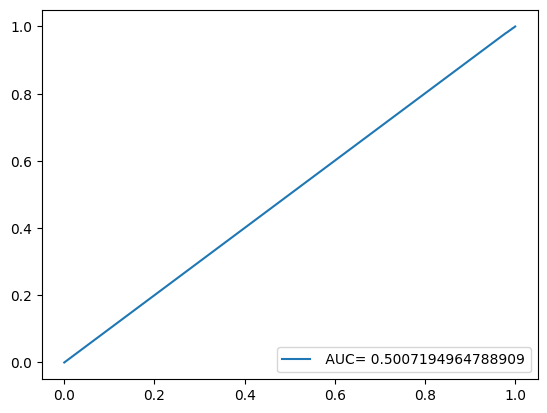

In [ ]:
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics. roc_curve (y_test, y_pred_proba)
auc = metrics. roc_auc_score (y_test, y_pred_proba)

#create ROC curve
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.legend(loc=4)
plt.show()